## Setup

In [22]:
import os
import numpy as np
import pandas as pd #Dataframe, Series
from dotenv import load_dotenv

import sys
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials 

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt

%load_ext dotenv
%dotenv
%matplotlib inline

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


## Spotify Login
The below will bring you to a new page to log you in. For own use, make sure to fill in the necessary variables within your `.env` file.

In [2]:
username = ""
scope = 'user-library-read'
token = util.prompt_for_user_token(username,scope,client_id=os.environ['SPOTIPY_CLIENT_ID'],
                                   client_secret=os.environ['SPOTIPY_CLIENT_SECRET'],
                                   redirect_uri=os.environ['SPOTIPY_REDIRECT_URI'])
sp = spotipy.Spotify(auth=token)

To test whether the data works, I am going to print out the last songs that have been added to my account.


In [3]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

if token:
    sp = spotipy.Spotify(auth=token)
    results = sp.current_user_saved_tracks()
    for item in results['items']:
        track = item['track']
        print(track['name'] + ' - ' + track['artists'][0]['name'])
else:
    print("Can't get token for", username)

TV Volume - HOMESHAKE
Mandela - Danyél Waro
How Strange - Nicola Cruz Remix - FEATHERED SUN
Todas Juntas (feat. Vicente García) - Leonel García
Dame Tu Consuelo - Mateo Kingman
11 PM - Maluma
HP - Maluma
No Se Me Quita (feat. Ricky Martin) - Maluma
Dispuesto (feat. Ozuna) - Maluma
No Puedo Olvidarte (feat. Nicky Jam) - Maluma
Me Enamoré de Ti - Maluma
Extrañándote (feat. Zion & Lennox) - Maluma
Shhh (Calla') - Maluma
Dinero Tiene Cualquiera - Maluma
Soltera (feat. Madonna) - Maluma
Te Quiero - Maluma
Instinto Natural (feat. Sech) - Maluma
Tu Vecina (feat. Ty Dolla $ign) - Maluma
La Flaca (feat. Chencho Corleone) - Maluma
Puesto Pa' Ti (feat. Farina) - Maluma


## Data Gathering
Now we need to gather the data; tracks I like and tracks I dislike. I have put together a playlist of songs I enjoy, and this can be fetched by the method `sp.user_playlist(<USER_ID>, <PLAYLIST_ID)`.

The User ID you can get by getting the sharing link of your user account, it's the number after `http://open.spotify.com/user/`.

The Playlist ID you can get by fetching the sharing link of the playlist, between `playlist/` and the questionmark `?`.

In [4]:
def populate_ids(playlist):
    ids = []
    tracks = playlist["tracks"]
    songs = tracks["items"] 
    
    while tracks['next']:
        tracks = sp.next(tracks)
        for item in tracks["items"]:
            songs.append(item)
            
    for song in songs:
        ids.append(song['track']['id']) 
    return ids

# "Good" Songs
good_playlist = sp.user_playlist("118049859", "2UVYOKEqsq9VNLfj1w9eJY")
good_ids = populate_ids(good_playlist)

# "Bad" Songs
bad_playlist = sp.user_playlist("118049859", "3Chmr7xcj52vd6eItEsMj1")
bad_ids = populate_ids(bad_playlist)

print("length good playlist: ", len(good_ids))
print("length bad playlist: ", len(bad_ids))

length good playlist:  1103
length bad playlist:  929


In [5]:
def add_to_features(ids, target):
    for i in range(0,len(ids),50):
        audio_features = sp.audio_features(good_ids[i:i+50])
        for track in audio_features:
            features.append(track)
            features[-1]['target'] = target

# we are splitting the "good" and "bad" tracks by giving a different target value
features = []
add_to_features(good_ids, 1)
add_to_features(bad_ids, 0)

## Data Analysis
Now let's have a look at the data we have been collecting. First, let's see what data we are receiving from Spotify. We see features like `acousticness`, `danceability` and `instrumentalness` that already seem interesting.

In [6]:
trainingData = pd.DataFrame(features)
trainingData.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,target,tempo,time_signature,track_href,type,uri,valence
0,0.0859,https://api.spotify.com/v1/audio-analysis/1ONQ...,0.328,282296,0.298,1ONQlRiCdcB8fTrZNqjq9x,0.000458,0,0.1230,-13.769,1,0.0333,1,168.142,4,https://api.spotify.com/v1/tracks/1ONQlRiCdcB8...,audio_features,spotify:track:1ONQlRiCdcB8fTrZNqjq9x,0.374
1,0.9230,https://api.spotify.com/v1/audio-analysis/7zyz...,0.616,191135,0.187,7zyz52PSMHpxkCeyyhWE03,0.000000,7,0.1170,-9.552,1,0.0671,1,166.925,4,https://api.spotify.com/v1/tracks/7zyz52PSMHpx...,audio_features,spotify:track:7zyz52PSMHpxkCeyyhWE03,0.413
2,0.6190,https://api.spotify.com/v1/audio-analysis/6XOy...,0.683,198613,0.565,6XOyWTU6Q35l7sZwl5lVes,0.000005,7,0.1220,-9.161,0,0.1200,1,112.896,5,https://api.spotify.com/v1/tracks/6XOyWTU6Q35l...,audio_features,spotify:track:6XOyWTU6Q35l7sZwl5lVes,0.508
3,0.4240,https://api.spotify.com/v1/audio-analysis/31xB...,0.747,174381,0.665,31xBPbLPTA2pscW0TAbt4D,0.005560,2,0.1440,-6.853,0,0.2040,1,176.075,4,https://api.spotify.com/v1/tracks/31xBPbLPTA2p...,audio_features,spotify:track:31xBPbLPTA2pscW0TAbt4D,0.426
4,0.4220,https://api.spotify.com/v1/audio-analysis/7zFX...,0.658,278180,0.294,7zFXmv6vqI4qOt4yGf3jYZ,0.000052,4,0.0749,-8.533,0,0.0321,1,74.038,4,https://api.spotify.com/v1/tracks/7zFXmv6vqI4q...,audio_features,spotify:track:7zFXmv6vqI4qOt4yGf3jYZ,0.358


In [7]:
# To be refactored, currently present to have a quick look around the data.

pos_tempo = trainingData[trainingData['target'] == 1]['tempo']
neg_tempo = trainingData[trainingData['target'] == 0]['tempo']
pos_dance = trainingData[trainingData['target'] == 1]['danceability']
neg_dance = trainingData[trainingData['target'] == 0]['danceability']
pos_duration = trainingData[trainingData['target'] == 1]['duration_ms']
neg_duration = trainingData[trainingData['target'] == 0]['duration_ms']
pos_loudness = trainingData[trainingData['target'] == 1]['loudness']
neg_loudness = trainingData[trainingData['target'] == 0]['loudness']
pos_speechiness = trainingData[trainingData['target'] == 1]['speechiness']
neg_speechiness = trainingData[trainingData['target'] == 0]['speechiness']
pos_valence = trainingData[trainingData['target'] == 1]['valence']
neg_valence = trainingData[trainingData['target'] == 0]['valence']
pos_energy = trainingData[trainingData['target'] == 1]['energy']
neg_energy = trainingData[trainingData['target'] == 0]['energy']
pos_acousticness = trainingData[trainingData['target'] == 1]['acousticness']
neg_acousticness = trainingData[trainingData['target'] == 0]['acousticness']
pos_key = trainingData[trainingData['target'] == 1]['key']
neg_key = trainingData[trainingData['target'] == 0]['key']
pos_instrumentalness = trainingData[trainingData['target'] == 1]['instrumentalness']
neg_instrumentalness = trainingData[trainingData['target'] == 0]['instrumentalness']

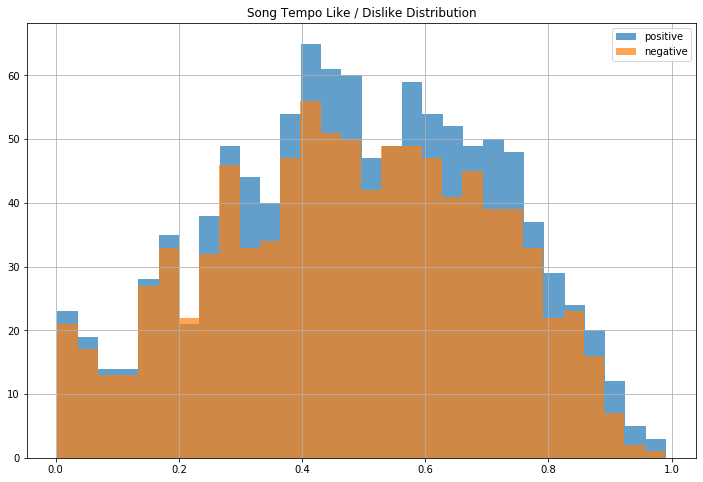

In [16]:
fig = plt.figure(figsize=(12,8))
plt.title("Song Tempo Like / Dislike Distribution")
pos_energy.hist(alpha=0.7, bins=30, label='positive')
neg_energy.hist(alpha=0.7, bins=30, label='negative')
plt.legend(loc='upper right')

## Training the Data
We will be using 85% of the data to train on, and 15% is left for testing purposes.

In [18]:
train, test = train_test_split(trainingData, test_size = 0.15)
features = ["danceability",
            "loudness",
            "valence",
            "energy",
            "instrumentalness",
            "acousticness",
            "key",
            "speechiness",
            "duration_ms"
           ]

x_train = train[features]
y_train = train["target"]

x_test = test[features]
y_test = test["target"]

Decision Tree Classification:

In [23]:
c = DecisionTreeClassifier(min_samples_split=100)
dt = c.fit(x_train, y_train)
y_pred = c.predict(x_test)
score = accuracy_score(y_test, y_pred) * 100
print("Accuracy using Decision Tree: ", round(score, 1), "%")

Accuracy using Decision Tree:  24.7 %
